In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from scipy.linalg import khatri_rao
%matplotlib inline

from pdb import set_trace

## Helper Functions

In [447]:
def gen_random_T(d,n,o):
 #list of orthogonal tensors that make up T

    A0 = ortho_group.rvs(n)[:,:d]
    T,T_hat = tensorize_U(A0,d,n,o)
    # for i in range(d):
    #     ui = A0[:,i].reshape(-1,1)
    #     Ui = np.tile(ui.T, (3, 1)).T
    #     # print(Ui)
    #     A = np.multiply.reduce(np.ix_(*Ui.T))
    #     T_hat[i,...] = A
    #     T = T+A

    return T, A0

def tensorize_U (A0,d,n,o):
    T = np.zeros(tuple(n*np.ones(o,dtype=np.int8)))
    T_hat = np.zeros((d,)+tuple(n*np.ones(o,dtype=np.int8)))

    for i in range(d):
        ui = A0[:,i].reshape(-1,1)
        Ui = np.tile(ui.T, (3, 1)).T
        # print(Ui)
        A = np.multiply.reduce(np.ix_(*Ui.T))
        T_hat[i,...] = A
        T = T+A
    return T,T_hat

gen_random_T(3,3,3)

C:\Users\thomas\AppData\Local\Temp\ipykernel_18500\1866006931.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.multiply.reduce(np.ix_(*Ui.T))


(array([[[ 0.79392912,  0.27375961,  0.04506597],
         [ 0.27375961,  0.23502607, -0.2820605 ],
         [ 0.04506597, -0.2820605 ,  0.03704744]],
 
        [[ 0.27375961,  0.23502607, -0.2820605 ],
         [ 0.23502607, -0.00923388,  0.56968764],
         [-0.2820605 ,  0.56968764,  0.0793199 ]],
 
        [[ 0.04506597, -0.2820605 ,  0.03704744],
         [-0.2820605 ,  0.56968764,  0.0793199 ],
         [ 0.03704744,  0.0793199 ,  0.70638551]]]),
 array([[ 0.35842654,  0.91110234, -0.20352625],
        [-0.67615671,  0.40367686,  0.61632549],
        [ 0.64369443, -0.08329177,  0.76073646]]))

In [427]:
def reconstruction_error(T,x,o):
    #sum = np.zeros(tuple(n*np.ones(o,dtype=np.int8)))
    # for i in range(d):
    #     sum += x[i,...]
    n = x.shape[0]
    d = x.shape[1]

    A,_ = tensorize_U(x,d,n,o)
    # print(A)
    error = T-A
    return np.linalg.norm(error.flatten('F'),2)**2

def normalized_reconstruction_error(T,x,o):
    return reconstruction_error(T,x,o)/np.linalg.norm(T.flatten('F'))**2

test= np.ones(tuple(n*np.ones(o,dtype=np.int8)))

T,A0 = gen_random_T(3,5,3) #dno
print(normalized_reconstruction_error(T,A0,3))


0.0


C:\Users\thomas\AppData\Local\Temp\ipykernel_18500\1866006931.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.multiply.reduce(np.ix_(*Ui.T))


## Algorithms

In [4]:
#optional

# Implementation of Higer Order Power method for eigen tensor computation
def PM(A0, ninner=1000, eps=1e-6):
    '''
    Input: 
        A0:     Tensor of interest (N by N)
        niter: Maximum number of iterations
        eps:   Tolerance 
    Intermediate: 
        N:     Number of columns of A
    Output: 
        u1:  leading eigen vector (unique up to sign) 
    '''   
    N = A0.shape[1]
    v1 = np.ones((N,1))
    for itr in range(ninner):
        v_new = np.dot(A0, v1)/np.linalg.norm(np.dot(A0,v1))
        if np.linalg.norm(v_new-v1)/np.linalg.norm(v1)<eps:
            v1 = v_new
            break 
        v1 = v_new
    v1 = np.sqrt(np.linalg.norm(np.dot(A0,v1)))*v1
    return v1

In [282]:
# Implementation of Gradient Descent
def GD(x, gf, fun=lambda x,itr: 0, niter=100, eps=1e-1):    
    '''
    Input: 
        x:     intilalization 
        gf:    gradient function takes position argument 
        eta:   step size
        fun:   objective value takes position argument 
        niter: number of iterations 
        eps:   tolerance for termination criteria 

    Itermediate: 
        grad:  gradient

    Output: 
        x:     final solution 
        itr:   numer of iteration 
        out:   objective values per iterations 
    '''
    out=np.empty(niter+1)
    d = len(x)
    out[0] = fun(x)
    for itr in range(niter):
        grad = gf(x)
        x = x - .0005*(grad)
        # print(grad)
        out[itr+1] = fun(x)
        # if np.abs(out[itr+1]-out[itr])/np.abs(out[itr])<eps:
        if np.abs(out[itr+1])<eps:
            break

    return x, itr, out[:itr+1]

In [287]:
# Implementation of Noisy Gradient Descent
def NGD(x, gf, fun=lambda x,itr: 0, niter=100, eps=1e-1):    
    '''
    Input: 
        x:     intilalization 
        gf:    gradient function takes position argument 
        eta:   step size
        fun:   objective value takes position argument 
        niter: number of iterations 
        eps:   tolerance for termination criteria 

    Itermediate: 
        grad:  gradient

    Output: 
        x:     final solution 
        itr:   numer of iteration 
        out:   objective values per iterations 
    '''
    out=np.empty(niter+1)
    d = len(x)
    out[0] = fun(x)
    for itr in range(niter):
        grad = gf(x)

        noise = np.random.rand(x.shape[0],x.shape[1])*2-1
        noise = 100*noise / np.linalg.norm(noise)
        # print(noise)
        # print(grad)
        x = x - .0005*(grad+noise)#/np.sqrt(itr+1)

        out[itr+1] = fun(x)
        # if np.abs(out[itr+1]-out[itr])/np.abs(out[itr])<eps:
        if np.abs(out[itr+1])<eps:
            break

    return x, itr, out[:itr+1]

In [437]:
# Implementation of Noisy ADMM
def NADMM(x, gf, fun=lambda x,itr: 0, niter=100, eps=1e-6):    
    '''
    Input: 
        x:     intilalization 
        gf:    gradient function takes position argument 
        eta:   step size
        fun:   objective value takes position argument 
        niter: number of iterations 
        eps:   tolerance for termination criteria 

    Itermediate: 
        grad:  gradient

    Output: 
        x:     final solution 
        itr:   numer of iteration 
        out:   objective values per iterations 
    '''
    out=np.empty(niter+1)
    d = len(x)

    a=x.copy()
    b=x.copy()
    c=x.copy()

    out[0] = fun(x)
    for itr in range(niter):
        grada,gradb,gradc = gf(a,b,c)

        noise = np.random.rand(x.shape[0],x.shape[1])
        noise = 0.1*noise / np.linalg.norm(noise)

        a = a - .0005*(grada+noise)#/np.sqrt(itr+1)
        b = b - .0005*(gradb+noise)#/np.sqrt(itr+1)
        c = c - .0005*(gradc+noise)#/np.sqrt(itr+1)

        out[itr+1] = fun((a+b+c) /3)
        if np.abs(out[itr+1]-out[itr])/np.abs(out[itr])<eps:
        # if np.abs(out[itr+1])<eps:
            x=(a+b+c) /3
            break
    x=(a+b+c) /3        
    return x, itr, out[:itr+1]

In [6]:
# Implementation of SGD with projection
def SGD(x, sgf, bt, fun=lambda x,itr: 0, proj=lambda x: x, nepoch=100, eps=1e-5):
    '''
    Input: 
        x:      intilalization 
        sgf:    stochastic gradient function takes position argument 
        bt:     batch size
        fun:    objective value takes position argument 
        nepoch: number of iterations 
        eps:    tolerance for termination criteria 

    Itermediate: 
        d:      length of x  
        sgrad:  stochastic gradient

    Output: 
        x:      final solution 
        epoch:  number of epoches
        itr:    total number of iterations 
        out:    objective values per iterations 
    '''
    itr = 0
    d = len(x)
    out= np.empty(nepoch+1)
    out[0] = fun(x.reshape(d,1),0)
    for epoch in range(nepoch):
        for i in range(bt):
            sgrad = sgf(x,i)
            itr +=1
            x = x - (sgrad)/np.sqrt(itr+1)
            x = proj(x)
        out[epoch+1] = fun(x.reshape(d,1),itr)
        if np.abs(out[epoch+1]-out[epoch])/np.abs(out[epoch])<eps:
            break
    return x, epoch, out[:epoch+1]

In [57]:
# Implementation of NSGD with projection
def NSGD(x, sgf, bt, fun=lambda x,itr: 0, proj=lambda x: x, nepoch=100, eps=1e-5):
    '''
    Input: 
        x:      intilalization 
        sgf:    stochastic gradient function takes position argument 
        bt:     batch size
        fun:    objective value takes position argument 
        nepoch: number of iterations 
        eps:    tolerance for termination criteria 

    Itermediate: 
        d:      length of x  
        sgrad:  stochastic gradient

    Output: 
        x:      final solution 
        epoch:  number of epoches
        itr:    total number of iterations 
        out:    objective values per iterations 
    '''
    itr = 0
    d = len(x)
    out= np.empty(nepoch+1)
    out[0] = fun(x.reshape(d,1),0)
    for epoch in range(nepoch):
        noise = np.random.rand(d)
        noise = noise / np.linalg.norm(noise)
        for i in range(bt):
            sgrad = sgf(x,i)
            itr +=1
            x = x - 0.5*(sgrad+noise)/np.sqrt(itr+1)
            x=proj(x)
        out[epoch+1] = fun(x.reshape(d,1),itr)
        if np.abs(out[epoch+1]-out[epoch])/np.abs(out[epoch])<eps:
            break
    return x, epoch, out[:epoch+1]

## Generating Data 

In [38]:
## Generating Data
    
np.random.seed(0)


o = 3 # order of tensor
n = 10 #dimensions of vectors, must be greater than order
d = 3 #number of orthogonal tensors


# A0 = ortho_group.rvs(d)[:,:o]
# # A0 = np.array([[1,0],[1,1]])
# A = np.multiply.reduce(np.ix_(*A0.T)) #np.einsum('i,j,k',A)


T,U = gen_random_T(d,n,o)
    

# print(T_hat)
# print("\n")
# print(T)

C:\Users\thomas\AppData\Local\Temp\ipykernel_18500\1866006931.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.multiply.reduce(np.ix_(*Ui.T))


## Tensor Decomp using NSGD and main algo

In [9]:
Niter = 1000
batch_size= 100

obj =  lambda x:         #input is a list of tensors
sgf = lambda x,i: 
proj = lambda x: x/np.linalg.norm(x)

a,out_nsgd = NSGD(np.zeros([n+1,]), sgf=sgf, bt=batch_size, fun=obj, niter=Niter)

SyntaxError: invalid syntax (1809582688.py, line 4)

In [ ]:
# Converence to the optimal value 
plt.plot(np.arange(len(out_nsgd)-1),np.log10(np.array(out_nsgd[:-1]-out_nsgd[-1])),'r')

plt.legend((r'RGD'), loc = 'upper right')

NameError: name 'out_nsgd' is not defined

## Tensor Decomp using Reconstruction error

In [394]:
#order must = 3
def grad_function(T,A,B,C): #A is a matrix containing the u's as columns
    d=A.shape[1]

    had = lambda a,b: np.multiply(a.T@a,b.T@b)
    kr = lambda a,b: khatri_rao(a,b)
    
    # print(np.kron(np.eye(n), np.multiply(C.T@C,B.T@B)).dot(A.flatten('F')).shape)

    gA = np.kron(np.eye(n), had(C,B)).dot(A.flatten('F')) - np.kron(np.eye(n),kr(C,B)).T.dot(np.reshape(T,(n*n,n)).flatten('F')) 
    gB = np.kron(np.eye(n), had(A,C)).dot(B.flatten('F')) - np.kron(np.eye(n),kr(A,C)).T.dot(np.reshape(T,(n*n,n)).flatten('F'))
    gC = np.kron(np.eye(n), had(B,A)).dot(C.flatten('F')) - np.kron(np.eye(n),kr(B,A)).T.dot(np.reshape(T,(n*n,n)).flatten('F'))
    
    gA=gA.reshape(A.shape)+ 2*A-B-C
    gB=gB.reshape(B.shape)+ 2*B-A-C
    gC=gC.reshape(C.shape)+ 2*C-B-A

    # print(gA)
    # print(had)
    # print(np.kron(np.eye(n), had)@A.flatten('F').T)
    # print(np.kron(np.eye(n),kr).T@np.reshape(T,(n*n,n)).flatten('F'))
    # g = np.block([gA,gA,gA]).reshape(-1,1)
    return gA,gB,gC


# g = grad_function(T,U)
# print(g)
# print(U-g)
# print(U_truth)


In [445]:
o = 3 # order of tensor
n = 10 #dimensions of vectors, must be greater than order
d = 3 #number of orthogonal tensors

T,U_truth = gen_random_T(d,n,o)
U = np.random.rand(n,d)#-0.01*np.ones((n,d)) #/np.linalg.norm(np.ones((n,d)),'fro')
U_n = 1*np.ones((n,d)) #/np.linalg.norm(np.ones((n,d)),'fro')

C:\Users\thomas\AppData\Local\Temp\ipykernel_18500\4260122597.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.multiply.reduce(np.ix_(*Ui.T))


In [448]:
Niter = 10000
batch_size= 100

obj =  lambda x: reconstruction_error(T,x,o)  #input is a list of tensors
# sgf = lambda x,i: 
gf = lambda a,b,c: grad_function(T,a,b,c)
proj = lambda x: x/np.linalg.norm(x.flatten('F'))

U_guess,itr,out_gd = NADMM(U, gf=gf, fun=obj, niter=Niter)
# U_guess,itr,out_gd = GD(U, gf=gf, fun=obj, niter=Niter)
# U_n_guess,itr_n,out_ngd = NGD(U_n, gf=gf, fun=obj, niter=Niter)

print(itr)
# print(itr_n)

print(reconstruction_error(T,U,o))
print(reconstruction_error(T,U*0,o))
print(reconstruction_error(T,U_guess,o))
# print(reconstruction_error(T,U_n_guess,o))

print(U_guess)
# print(U_n_guess)
print(U_truth)

C:\Users\thomas\AppData\Local\Temp\ipykernel_18500\1866006931.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.multiply.reduce(np.ix_(*Ui.T))
C:\Users\thomas\AppData\Local\Temp\ipykernel_18500\1866006931.py:24: RuntimeWarning: overflow encountered in multiply
  A = np.multiply.reduce(np.ix_(*Ui.T))
C:\Users\thomas\AppData\Local\Temp\ipykernel_18500\1866006931.py:24: RuntimeWarning: overflow encountered in reduce
  A = np.multiply.reduce(np.ix_(*Ui.T))
C:\Users\thomas\AppData\Local\Temp\ipykernel_18500\1280325262.py:5: RuntimeWarning: overflow encountered in multiply
  had = lambda a,b: np.multiply(a.T@a,b.T@b)


9999
52.086846047061854
194.94673880097233
nan
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[0.70362376 0.43453391 0.66459765]
 [0.51840077 0.6958461  0.19433776]
 [0.76670607 0.31941861 0.1948694 ]
 [0.69332144 0.77487972 0.63936403]
 [0.66736023 0.61183847 0.55235413]
 [0.51694762 0.2280472  0.58559963]
 [0.29110559 0.49585004 0.43686414]
 [0.47059945 0.56625264 0.45482647]
 [0.65719441 0.42996326 0.5183394 ]
 [0.45325116 0.44158731 0.52279967]]


11.888403066326516


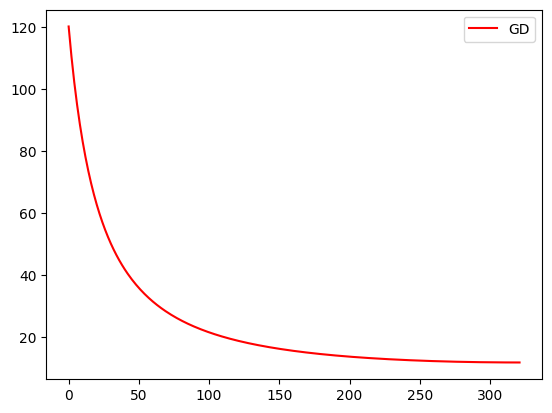

In [443]:
# Converence to the optimal value 
# print(np.multiply.reduce(np.ix_(*U_guess.T)))
# print(T)
# print(T)

# plt.plot(np.arange(len(out_gd)-1),np.log10(np.array(out_gd[:-1]-out_gd[-1])),'r')
# plt.plot(np.arange(len(out_ngd)-1),np.log10(np.array(out_ngd[:-1]-out_ngd[-1])),'b')

plt.plot(np.arange(len(out_gd)),(np.array(out_gd[:])),'r')
# plt.plot(np.arange(len(out_ngd)-1),np.log10(np.array(out_ngd[:-1])),'b')

print(out_gd[-1])
# print(out_ngd[-1])
plt.legend(('GD', 'noisy GD'), loc = 'upper right')